# Import Module & dataset

In [1]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install tensorflow
%pip install scikit-learn
%pip install arch
%pip install matplotlib
%pip install pandas
%pip install numpy
%pip install altair
%pip install statsmodels
%pip install scipy
%pip install yfinance
%pip install seaborn

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import altair as alt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
import seaborn as sns

Read Dataset

In [23]:
buku_000 = pd.read_csv('D:\\KuliYeah\\Season 7\\Arc Skripsi\\forecasting\\buku_000.csv')
buku_100 = pd.read_csv('D:\\KuliYeah\\Season 7\\Arc Skripsi\\forecasting\\buku_100.csv')
buku_200 = pd.read_csv('D:\\KuliYeah\\Season 7\\Arc Skripsi\\forecasting\\buku_200.csv')
buku_300 = pd.read_csv('D:\\KuliYeah\\Season 7\\Arc Skripsi\\forecasting\\buku_300.csv')
buku_400 = pd.read_csv('D:\\KuliYeah\\Season 7\\Arc Skripsi\\forecasting\\buku_400.csv')
buku_500 = pd.read_csv('D:\\KuliYeah\\Season 7\\Arc Skripsi\\forecasting\\buku_500.csv')
buku_600 = pd.read_csv('D:\\KuliYeah\\Season 7\\Arc Skripsi\\forecasting\\buku_600.csv')
buku_700 = pd.read_csv('D:\\KuliYeah\\Season 7\\Arc Skripsi\\forecasting\\buku_700.csv')
buku_800 = pd.read_csv('D:\\KuliYeah\\Season 7\\Arc Skripsi\\forecasting\\buku_800.csv')
buku_900 = pd.read_csv('D:\\KuliYeah\\Season 7\\Arc Skripsi\\forecasting\\buku_900.csv')

buku_000['Bulan'] = pd.to_datetime(buku_000['Bulan'], format='%m/%y')
buku_100['Bulan'] = pd.to_datetime(buku_100['Bulan'], format='%m/%y')
buku_200['Bulan'] = pd.to_datetime(buku_200['Bulan'], format='%m/%y')
buku_300['Bulan'] = pd.to_datetime(buku_300['Bulan'], format='%m/%y')
buku_400['Bulan'] = pd.to_datetime(buku_400['Bulan'], format='%m/%y')
buku_500['Bulan'] = pd.to_datetime(buku_500['Bulan'], format='%m/%y')
buku_600['Bulan'] = pd.to_datetime(buku_600['Bulan'], format='%m/%y')
buku_700['Bulan'] = pd.to_datetime(buku_700['Bulan'], format='%m/%y')
buku_800['Bulan'] = pd.to_datetime(buku_800['Bulan'], format='%m/%y')
buku_900['Bulan'] = pd.to_datetime(buku_900['Bulan'], format='%m/%y')

# Peminjaman buku kategori general

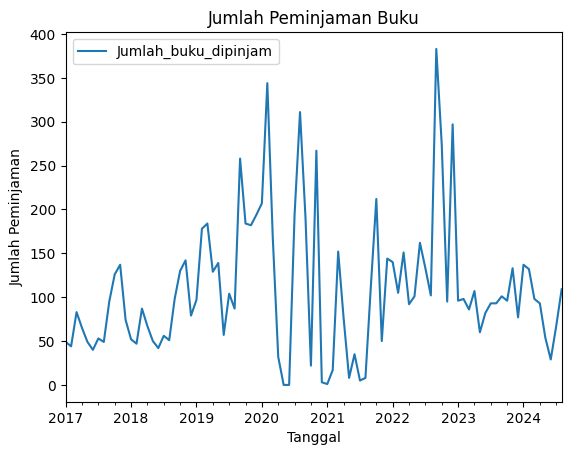

In [24]:
buku_000.plot(x='Bulan', y='Jumlah_buku_dipinjam', kind='line')
plt.title('Jumlah Peminjaman Buku')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Peminjaman')
plt.show()

Cek volatil

In [25]:
# Langkah 1: Periksa apakah ada nilai NaN di kolom 'Jumlah_buku_dipinjam'
print(f"Jumlah NaN di kolom 'Jumlah_buku_dipinjam': {buku_000['Jumlah_buku_dipinjam'].isna().sum()}")

# Jika ada NaN di kolom Jumlah_buku_dipinjam, hapus baris tersebut
buku_000_clean = buku_000.dropna(subset=['Jumlah_buku_dipinjam'])

# Langkah 2: Hitung perubahan persen antar periode
buku_000_clean['pct_change'] = buku_000_clean['Jumlah_buku_dipinjam'].pct_change()

# Langkah 3: Periksa apakah ada nilai inf atau -inf di kolom pct_change
print(f"Jumlah inf di kolom 'pct_change': {np.isinf(buku_000_clean['pct_change']).sum()}")

# Ganti nilai inf dengan NaN
buku_000_clean['pct_change'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Hapus nilai NaN dari pct_change
df_clean = buku_000_clean['pct_change'].dropna()

# Langkah 4: Hitung standar deviasi dari perubahan persen
std_dev = np.std(df_clean)

# Langkah 5: Tampilkan standar deviasi
print(f'Standar deviasi dari perubahan persentase: {std_dev}')

# Langkah 6: Buat threshold untuk menentukan apakah data volatil atau tidak
threshold = 0.1  # Contoh threshold 10%
if std_dev > threshold:
    print("Data dianggap volatil")
else:
    print("Data tidak dianggap volatil")

Jumlah NaN di kolom 'Jumlah_buku_dipinjam': 0
Jumlah inf di kolom 'pct_change': 1
Standar deviasi dari perubahan persentase: 2.6592216299780524
Data dianggap volatil


C:\Users\asus\AppData\Local\Temp\ipykernel_17732\500041157.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  buku_000_clean['pct_change'].replace([np.inf, -np.inf], np.nan, inplace=True)


Outlier handling

In [20]:
# Menghitung Q1, Q3 dan IQR
Q1 = buku_000['Jumlah_buku_dipinjam'].quantile(0.25)
Q3 = buku_000['Jumlah_buku_dipinjam'].quantile(0.75)
IQR = Q3 - Q1

# Batas bawah dan atas untuk outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
buku_000
outliers_000 = buku_000[(buku_000['Jumlah_buku_dipinjam'] < lower_bound) | (buku_000['Jumlah_buku_dipinjam'] > upper_bound)]

print(outliers_000)
# Menampilkan batas bawah dan atas
print(f"Batas bawah: {lower_bound}")
print(f"Batas atas: {upper_bound}")

        Bulan  Jumlah_buku_dipinjam
37 2020-02-01                   344
43 2020-08-01                   311
68 2022-09-01                   383
69 2022-10-01                   274
71 2022-12-01                   297
Batas bawah: -77.0
Batas atas: 269.0


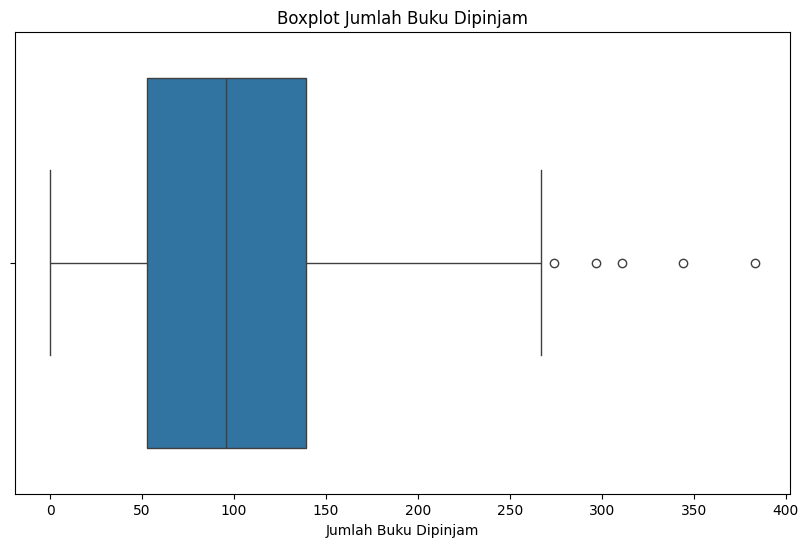

In [26]:
# Membuat boxplot untuk kolom 'Jumlah_buku_dipinjam'
plt.figure(figsize=(10, 6))
sns.boxplot(data=buku_000, x='Jumlah_buku_dipinjam')

# Menambahkan judul dan label
plt.title('Boxplot Jumlah Buku Dipinjam')
plt.xlabel('Jumlah Buku Dipinjam')

# Menampilkan boxplot
plt.show()


In [27]:
# Menambahkan beberapa outlier secara manual untuk contoh
buku_000.loc[37 , 'Jumlah_buku_dipinjam'] = 344
buku_000.loc[43, 'Jumlah_buku_dipinjam'] = 311
buku_000.loc[68 , 'Jumlah_buku_dipinjam'] = 383
buku_000.loc[69, 'Jumlah_buku_dipinjam'] = 274
buku_000.loc[71, 'Jumlah_buku_dipinjam'] = 297

# Menghitung Moving Average atau Median (misalnya window 3 bulan)
window_size = 6
# Menghitung Rolling Median
buku_000['rolling_median'] = buku_000['Jumlah_buku_dipinjam'].rolling(window=window_size, center=True).median()

# Menghitung batas toleransi outlier (misalnya 2 standar deviasi)
buku_000['rolling_std'] = buku_000['Jumlah_buku_dipinjam'].rolling(window=window_size, center=True).std()

# Batas atas dan bawah untuk deteksi outlier
tolerance = 1.5  # multiplier untuk standar deviasi
upper_bound = buku_000['rolling_median'] + tolerance * buku_000['rolling_std']
lower_bound = buku_000['rolling_median'] - tolerance * buku_000['rolling_std']

# Deteksi outlier
outliers = (buku_000['Jumlah_buku_dipinjam'] > upper_bound) | (buku_000['Jumlah_buku_dipinjam'] < lower_bound)

# Ganti outlier dengan rolling median
buku_000.loc[outliers, 'Jumlah_buku_dipinjam'] = buku_000.loc[outliers, 'rolling_median']

# Drop kolom rolling mean dan rolling std (opsional)
buku_000.drop(columns=['rolling_median', 'rolling_std'], inplace=True)

buku_000

C:\Users\asus\AppData\Local\Temp\ipykernel_17732\524918969.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 59.5 143.  188.  106.5  12.5  81.5 117.5 147.5  89.5 116.5  80. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  buku_000.loc[outliers, 'Jumlah_buku_dipinjam'] = buku_000.loc[outliers, 'rolling_median']


,Bulan,Jumlah_buku_dipinjam
0,2017-01-01,49.0
1,2017-02-01,44.0
2,2017-03-01,83.0
3,2017-04-01,65.0
4,2017-05-01,49.0
...,...,...
87,2024-04-01,93.0
88,2024-05-01,54.0
89,2024-06-01,80.0
90,2024-07-01,67.0


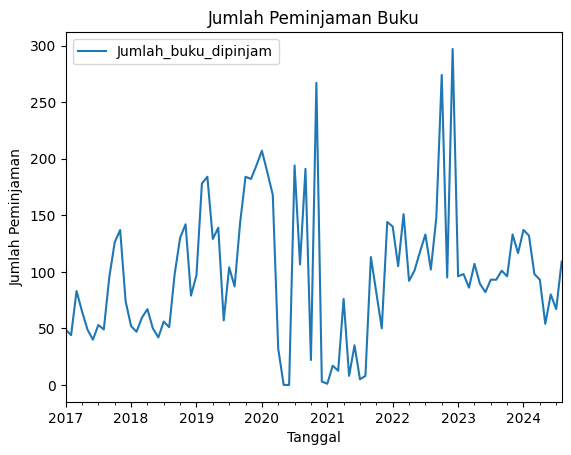

In [28]:
buku_000.plot(x='Bulan', y='Jumlah_buku_dipinjam', kind='line')
plt.title('Jumlah Peminjaman Buku')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Peminjaman')
plt.show()

CNN-GRU Forecasting

Data split 70:30

Epoch 1/170


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.3825
Epoch 2/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3965
Epoch 3/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2215
Epoch 4/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6663
Epoch 5/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7853 
Epoch 6/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1201 
Epoch 7/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1241
Epoch 8/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3807  
Epoch 9/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1992
Epoch 10/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0227
Epoch 11/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0805
Epoch 12/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1562  
Epoch 13/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0769 
Epoch 14/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062
Epoch 15/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0468
Epoch 16/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 

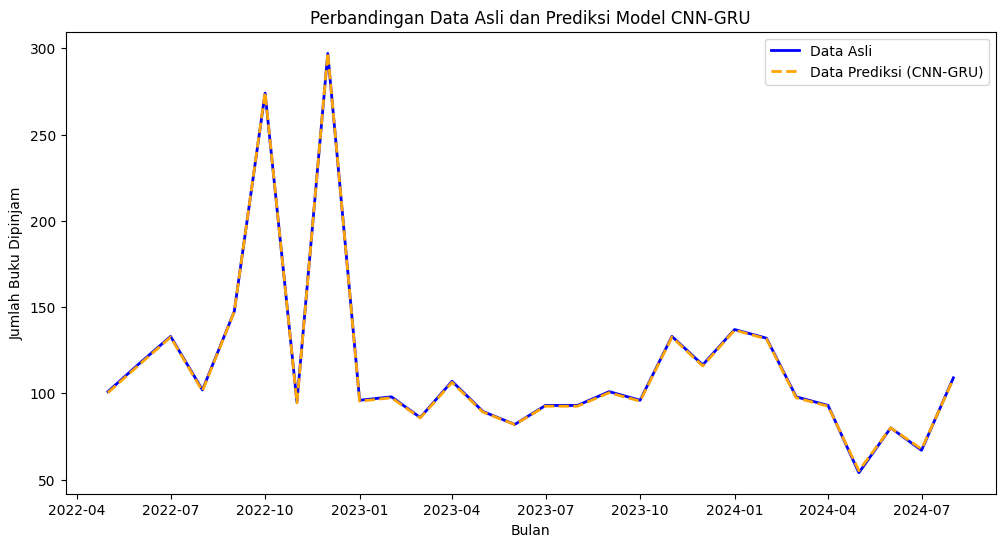

In [30]:
# Memisahkan fitur dan target
X = buku_000[['Jumlah_buku_dipinjam']]  # Changed here
y = buku_000[['Jumlah_buku_dipinjam']]  # Changed here

# Split data menjadi data latih dan data uji (70% latih, 30% uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Reshape input menjadi tiga dimensi
# Menggunakan 1 timestep (karena kita menggunakan data dari saat ini saja)
X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))  # timesteps=1
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))  # timesteps=1


# Normalisasi data (opsional jika diperlukan oleh model RNN)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Tentukan input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Model CNN-GRU
model_cnn_gru = Sequential()

# Lapisan CNN untuk ekstraksi fitur
model_cnn_gru.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
model_cnn_gru.add(MaxPooling1D(pool_size=1))
model_cnn_gru.add(Flatten())

# Ubah kembali ke bentuk tiga dimensi untuk input ke GRU
model_cnn_gru.add(Reshape((1, -1)))

# Lapisan GRU setelah CNN
model_cnn_gru.add(GRU(50, activation='relu'))

# Lapisan output
model_cnn_gru.add(Dense(1))

# Kompilasi model
model_cnn_gru.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
model_cnn_gru.fit(X_train, y_train_scaled, epochs=170, batch_size=32)

# Prediksi pada data uji
y_pred_cnn_gru = model_cnn_gru.predict(X_test)

y_pred_cnn_gru_inverse = scaler.inverse_transform(y_pred_cnn_gru)
y_test_scaled_inverse = scaler.inverse_transform(y_test_scaled)

# Evaluasi model
mse = mean_squared_error(y_test_scaled_inverse, y_pred_cnn_gru_inverse)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

# Visualisasi hasil prediksi dari model CNN-GRU
bulan = buku_000.iloc[-len(y_test):]['Bulan'].values  # Ambil data bulan dari data uji
plt.figure(figsize=(12, 6))
plt.plot(bulan, y_test_scaled_inverse, label='Data Asli', color='blue', linewidth=2)
plt.plot(bulan, y_pred_cnn_gru_inverse, label='Data Prediksi (CNN-GRU)', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Buku Dipinjam')
plt.title('Perbandingan Data Asli dan Prediksi Model CNN-GRU')
plt.legend()
plt.show()

Data split 80:20

Epoch 1/170


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 79.5964
Epoch 2/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4516 
Epoch 3/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.6309 
Epoch 4/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9038
Epoch 5/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2068 
Epoch 6/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1961
Epoch 7/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8906
Epoch 8/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3486 
Epoch 9/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4305
Epoch 10/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0413
Epoch 11/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5731
Epoch 12/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309
Epoch 13/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3384
Epoch 14/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3536 
Epoch 15/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0409 
Epoch 16/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 

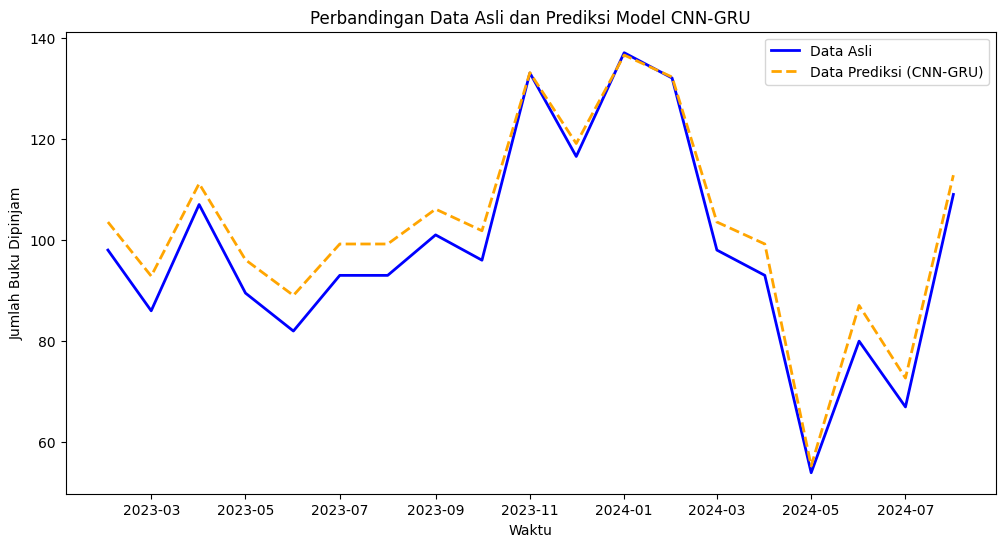

In [31]:
# Memisahkan fitur dan target
X = buku_000[['Jumlah_buku_dipinjam']]  # Changed here
y = buku_000[['Jumlah_buku_dipinjam']]  # Changed here

# Split data menjadi data latih dan data uji (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape input menjadi tiga dimensi
# Menggunakan 1 timestep (karena kita menggunakan data dari saat ini saja)
X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))  # timesteps=1
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))  # timesteps=1


# Normalisasi data (opsional jika diperlukan oleh model RNN)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Tentukan input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Model CNN-GRU
model_cnn_gru = Sequential()

# Lapisan CNN untuk ekstraksi fitur
model_cnn_gru.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
model_cnn_gru.add(MaxPooling1D(pool_size=1))
model_cnn_gru.add(Flatten())

# Ubah kembali ke bentuk tiga dimensi untuk input ke GRU
model_cnn_gru.add(Reshape((1, -1)))

# Lapisan GRU setelah CNN
model_cnn_gru.add(GRU(50, activation='relu'))

# Lapisan output
model_cnn_gru.add(Dense(1))

# Kompilasi model
model_cnn_gru.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
model_cnn_gru.fit(X_train, y_train_scaled, epochs=170, batch_size=32)

# Prediksi pada data uji
y_pred_cnn_gru = model_cnn_gru.predict(X_test)

y_pred_cnn_gru_inverse = scaler.inverse_transform(y_pred_cnn_gru)
y_test_scaled_inverse = scaler.inverse_transform(y_test_scaled)

# Evaluasi model
mse = mean_squared_error(y_test_scaled_inverse, y_pred_cnn_gru_inverse)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

# Visualisasi hasil prediksi dari model CNN-GRU
bulan = buku_000.iloc[-len(y_test):]['Bulan'].values  # Ambil data bulan dari data uji
plt.figure(figsize=(12, 6))
plt.plot(bulan, y_test_scaled_inverse, label='Data Asli', color='blue', linewidth=2)
plt.plot(bulan, y_pred_cnn_gru_inverse, label='Data Prediksi (CNN-GRU)', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Waktu')
plt.ylabel('Jumlah Buku Dipinjam')
plt.title('Perbandingan Data Asli dan Prediksi Model CNN-GRU')
plt.legend()
plt.show()

Data split 90:10

Epoch 1/170


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.5000
Epoch 2/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4169 
Epoch 3/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8181
Epoch 4/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3797 
Epoch 5/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1975
Epoch 6/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2351
Epoch 7/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1302
Epoch 8/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1415
Epoch 9/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232
Epoch 10/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0616
Epoch 11/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274
Epoch 12/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207
Epoch 13/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0377 
Epoch 14/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 15/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261
Epoch 16/170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

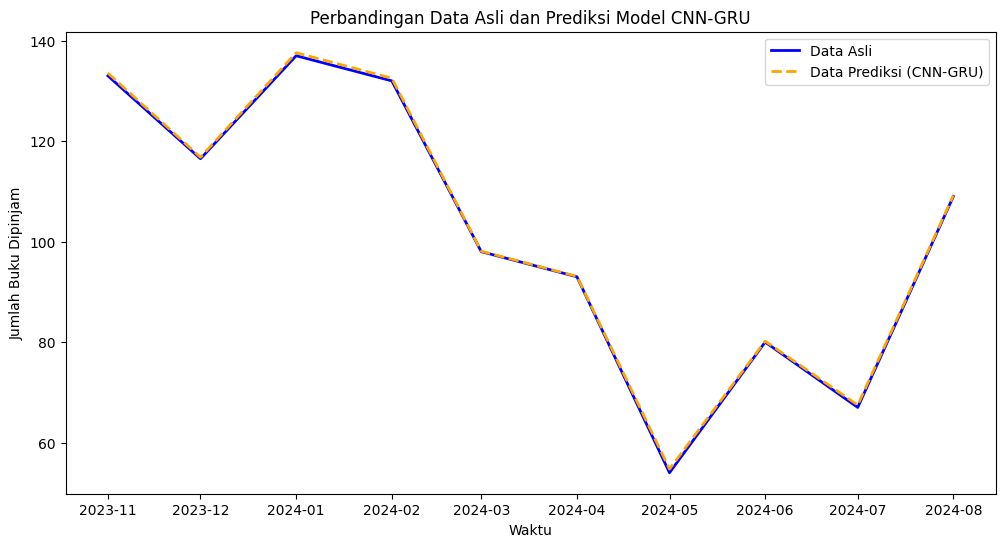

In [32]:
# Memisahkan fitur dan target
X = buku_000[['Jumlah_buku_dipinjam']]  # Changed here
y = buku_000[['Jumlah_buku_dipinjam']]  # Changed here

# Split data menjadi data latih dan data uji (90% latih, 10% uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Reshape input menjadi tiga dimensi
# Menggunakan 1 timestep (karena kita menggunakan data dari saat ini saja)
X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))  # timesteps=1
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))  # timesteps=1


# Normalisasi data (opsional jika diperlukan oleh model RNN)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Tentukan input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Model CNN-GRU
model_cnn_gru = Sequential()

# Lapisan CNN untuk ekstraksi fitur
model_cnn_gru.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
model_cnn_gru.add(MaxPooling1D(pool_size=1))
model_cnn_gru.add(Flatten())

# Ubah kembali ke bentuk tiga dimensi untuk input ke GRU
model_cnn_gru.add(Reshape((1, -1)))

# Lapisan GRU setelah CNN
model_cnn_gru.add(GRU(50, activation='relu'))

# Lapisan output
model_cnn_gru.add(Dense(1))

# Kompilasi model
model_cnn_gru.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
model_cnn_gru.fit(X_train, y_train_scaled, epochs=170, batch_size=32)

# Prediksi pada data uji
y_pred_cnn_gru = model_cnn_gru.predict(X_test)

y_pred_cnn_gru_inverse = scaler.inverse_transform(y_pred_cnn_gru)
y_test_scaled_inverse = scaler.inverse_transform(y_test_scaled)

# Evaluasi model
mse = mean_squared_error(y_test_scaled_inverse, y_pred_cnn_gru_inverse)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

# Visualisasi hasil prediksi dari model CNN-GRU
bulan = buku_000.iloc[-len(y_test):]['Bulan'].values  # Ambil data bulan dari data uji
plt.figure(figsize=(12, 6))
plt.plot(bulan, y_test_scaled_inverse, label='Data Asli', color='blue', linewidth=2)
plt.plot(bulan, y_pred_cnn_gru_inverse, label='Data Prediksi (CNN-GRU)', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Waktu')
plt.ylabel('Jumlah Buku Dipinjam')
plt.title('Perbandingan Data Asli dan Prediksi Model CNN-GRU')
plt.legend()
plt.show()

Forecasting 12 bulan kedepan

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.1644
Epoch 2/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1183
Epoch 3/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0926
Epoch 4/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0714
Epoch 5/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0507 
Epoch 6/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0404
Epoch 7/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0321
Epoch 8/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0298
Epoch 9/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0259 
Epoch 10/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0314
Epoch 11/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0299
Epoch 12/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0302
Epoch 13/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0285
Epoch 14/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0290
Epoch 15/170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0274 
Epoch 16/170
2/2

<ipython-input-14-cde82d6d6b45>:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date, periods=12, freq='M')
<ipython-input-14-cde82d6d6b45>:61: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=12, freq='M')
<ipython-input-14-cde82d6d6b45>:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_dates = pd.date_range(buku_000['Bulan'].iloc[0], periods=len(combined_data), freq='M')


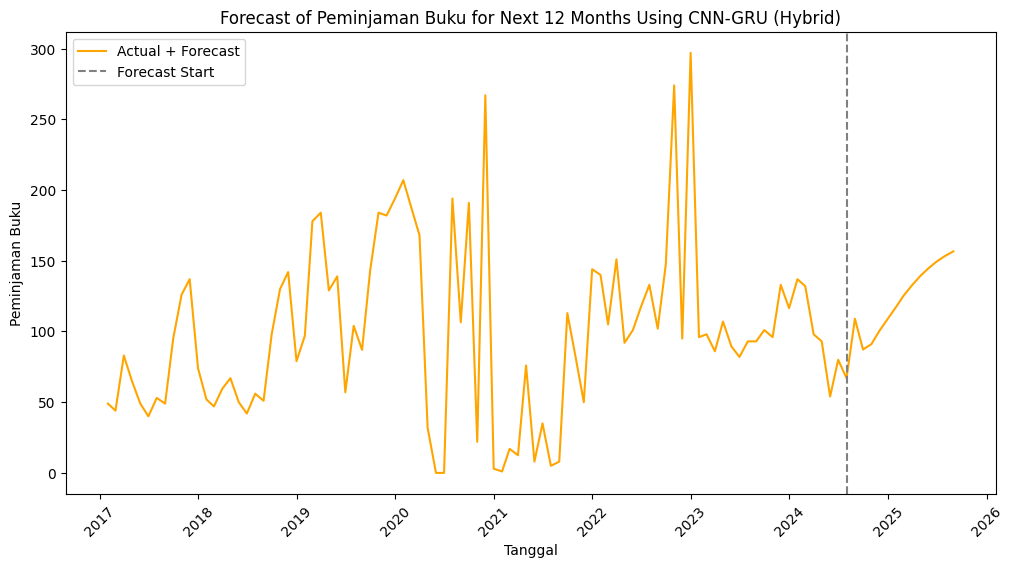

In [ ]:
# Tentukan jumlah minggu yang ingin digunakan sebagai input
timesteps = 50  # Menggunakan 12 minggu terakhir sebagai konteks

# Fungsi untuk membuat data dengan sliding window
def create_sliding_window_data(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(buku_000['Jumlah_buku_dipinjam'].values.reshape(-1, 1))

# Membuat data latih dengan sliding window
X, y = create_sliding_window_data(data_scaled, timesteps)
X_train, X_test = X[:-1], X[-1:]  # Menggunakan data terakhir di X_test untuk memulai prediksi
y_train = y[:-1]  # Tidak membutuhkan y_test di sini

# Model CNN-GRU
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=1))
model.add(GRU(50, activation='relu'))
model.add(Dense(1))

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
model.fit(X_train, y_train, epochs=170, batch_size=32, verbose=1)

# Hybrid Prediction: Prediksi Minggu Pertama + Iterasi untuk Prediksi 11 Minggu Berikutnya
predictions = []

# Prediksi minggu pertama
pred_first = model.predict(X_test)
predictions.append(pred_first[0, 0])

# Iterasi untuk prediksi minggu berikutnya
last_data = np.concatenate([X_test[:, 1:, :], np.array(pred_first).reshape((1, 1, 1))], axis=1)

for i in range(11):  # Melanjutkan untuk 11 minggu berikutnya
    pred = model.predict(last_data)
    predictions.append(pred[0, 0])

    # Update last_data dengan prediksi baru
    new_input = np.array(pred).reshape((1, 1, 1))
    last_data = np.concatenate([last_data[:, 1:, :], new_input], axis=1)

# Denormalisasi hasil prediksi ke skala asli
predictions_original = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Adjust future dates to start immediately after the last known date in the dataset
last_date = buku_000['Bulan'].iloc[-1]
future_dates = pd.date_range(last_date, periods=12, freq='M')

# Adjust future dates to start immediately after the last known date in the dataset
last_date = buku_000['Bulan'].iloc[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=12, freq='M')

# Ensure predictions have only 12 values
predictions_original = predictions_original[:12]

# Combine actual data with forecast for a continuous line
combined_data = np.concatenate([scaler.inverse_transform(data_scaled).flatten(), predictions_original.flatten()])
combined_dates = pd.date_range(buku_000['Bulan'].iloc[0], periods=len(combined_data), freq='M')

# Plot the combined actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(combined_dates, combined_data, label='Actual + Forecast', color='orange')
plt.axvline(last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title('Forecast of Peminjaman Buku for Next 12 Months Using CNN-GRU (Hybrid)')
plt.xlabel('Tanggal')
plt.ylabel('Peminjaman Buku')
plt.legend()
plt.xticks(rotation=45)
plt.show()


# Peminjaman buku kategori filosofi dan psikologi

In [ ]:
buku_100.plot(x='Bulan', y='Jumlah_buku_dipinjam', kind='line')
plt.title('Jumlah Peminjaman Buku')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Peminjaman')
plt.show()

Cek volatil

In [ ]:
import pandas as pd
import numpy as np

# Misal buku_100 adalah DataFrame yang berisi data Anda

# Langkah 1: Periksa apakah ada nilai NaN di kolom 'Jumlah_buku_dipinjam'
print(f"Jumlah NaN di kolom 'Jumlah_buku_dipinjam': {buku_100['Jumlah_buku_dipinjam'].isna().sum()}")

# Jika ada NaN di kolom Jumlah_buku_dipinjam, hapus baris tersebut
buku_100_clean = buku_100.dropna(subset=['Jumlah_buku_dipinjam'])

# Langkah 2: Hitung perubahan persen antar periode
buku_100_clean['pct_change'] = buku_100_clean['Jumlah_buku_dipinjam'].pct_change()

# Langkah 3: Periksa apakah ada nilai inf atau -inf di kolom pct_change
print(f"Jumlah inf di kolom 'pct_change': {np.isinf(buku_100_clean['pct_change']).sum()}")

# Ganti nilai inf dengan NaN
buku_100_clean['pct_change'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Hapus nilai NaN dari pct_change
df_clean = buku_100_clean['pct_change'].dropna()

# Langkah 4: Hitung standar deviasi dari perubahan persen
std_dev = np.std(df_clean)

# Langkah 5: Tampilkan standar deviasi
print(f'Standar deviasi dari perubahan persentase: {std_dev}')

# Langkah 6: Buat threshold untuk menentukan apakah data volatil atau tidak
threshold = 0.1  # Contoh threshold 10%
if std_dev > threshold:
    print("Data dianggap volatil")
else:
    print("Data tidak dianggap volatil")

Outlier handling

In [ ]:
# Menghitung Q1, Q3 dan IQR
Q1 = buku_100['Jumlah_buku_dipinjam'].quantile(0.25)
Q3 = buku_100['Jumlah_buku_dipinjam'].quantile(0.75)
IQR = Q3 - Q1

# Batas bawah dan atas untuk outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
buku_100
outliers_000 = buku_100[(buku_100['Jumlah_buku_dipinjam'] < lower_bound) | (buku_100['Jumlah_buku_dipinjam'] > upper_bound)]

print(outliers_000)
# Menampilkan batas bawah dan atas
print(f"Batas bawah: {lower_bound}")
print(f"Batas atas: {upper_bound}")

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(buku_100['Jumlah_buku_dipinjam'], model='additive', period=12)
result.plot()
plt.show()

In [ ]:
# Menambahkan beberapa outlier secara manual untuk contoh
buku_100.loc[26, 'Jumlah_buku_dipinjam'] = 245
buku_100.loc[27, 'Jumlah_buku_dipinjam'] = 221
buku_100.loc[28, 'Jumlah_buku_dipinjam'] = 192
buku_100.loc[32, 'Jumlah_buku_dipinjam'] = 204
buku_100.loc[37, 'Jumlah_buku_dipinjam'] = 341

# Menghitung Moving Average atau Median (misalnya window 3 bulan)
window_size = 6
# Menghitung Rolling Median
buku_100['rolling_median'] = buku_100['Jumlah_buku_dipinjam'].rolling(window=window_size, center=True).median()

# Menghitung batas toleransi outlier (misalnya 2 standar deviasi)
buku_100['rolling_std'] = buku_100['Jumlah_buku_dipinjam'].rolling(window=window_size, center=True).std()

# Batas atas dan bawah untuk deteksi outlier
tolerance =  1.5  # multiplier untuk standar deviasi
upper_bound = buku_100['rolling_median'] + tolerance * buku_100['rolling_std']
lower_bound = buku_100['rolling_median'] - tolerance * buku_100['rolling_std']

# Deteksi outlier
outliers = (buku_100['Jumlah_buku_dipinjam'] > upper_bound) | (buku_100['Jumlah_buku_dipinjam'] < lower_bound)

# Ganti outlier dengan rolling median
buku_100.loc[outliers, 'Jumlah_buku_dipinjam'] = buku_100.loc[outliers, 'rolling_median']

# Drop kolom rolling mean dan rolling std (opsional)
buku_100.drop(columns=['rolling_median', 'rolling_std'], inplace=True)
buku_100

In [ ]:
buku_100.plot(x='Bulan', y='Jumlah_buku_dipinjam', kind='line')
plt.title('Jumlah Peminjaman Buku')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Peminjaman')
plt.show()

CNN-GRU

In [ ]:
# Assume peminjaman_buku is your DataFrame
data = buku_100['Jumlah_buku_dipinjam'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set time step
time_step = 12  # Example: use the past 12 months to predict the next month
X, y = create_sequences(data_scaled, time_step)

# Split into training and testing sets (e.g., 90% train, 10% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for CNN and GRU (required format: [samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the hybrid CNN-GRU model
model = Sequential()

# Add CNN layers
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Add GRU layers
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))

# Add Dense layer to output predictions
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse scaling to get actual values
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mae = mean_absolute_error(y_test_actual, test_pred)
mse = mean_squared_error(y_test_actual, test_pred)
rmse = np.sqrt(mse)

# Print metrics
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual  Test Data')
plt.plot(range(len(y_test_actual)), test_pred, label='Predicted Test Data', linestyle='--')
# plt.plot(range(time_step, len(train_pred) + time_step), train_pred, label='Train Predictions')
# plt.plot(test.index, test.iloc[:,0], label='Actual Test')
# plt.plot(range(len(train_pred) + time_step, len(data) - 1), test_pred, label='Predictions', linestyle='--')
plt.title('Hybrid CNN-GRU Forecasting')
plt.xlabel('Time')
plt.ylabel('Jumlah Peminjaman')
plt.legend()
plt.show()

In [ ]:
# 4. Predict the next 3 months

# We need the last 'time_step' data points from the training data to predict the future
last_sequence = data_scaled[-time_step:]  # Take the last sequence from the data

# Reshape for CNN-GRU model input
last_sequence = last_sequence.reshape((1, time_step, 1))

# Predict the next 3 months iteratively
predictions = []

for i in range(12):  # Forecast for 3 months ahead
    next_pred = model.predict(last_sequence)
    predictions.append(next_pred[0][0])

    # Update the sequence: drop the first value and append the prediction
    # Reshape next_pred to match dimensions of last_sequence[:, 1:, :]
    next_pred_reshaped = next_pred.reshape(1, 1, 1)
    last_sequence = np.concatenate([last_sequence[:, 1:, :], next_pred_reshaped], axis=1)

# Inverse transform predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 5. Plot the results

# Plot the actual data and forecast
plt.figure(figsize=(10, 6))
plt.plot(range(len(data)), data, label='Actual Data')
plt.plot(range(len(data), len(data) + 12), predictions, label='3-Month Forecast', linestyle='--', color='red')
plt.title('Book Borrowing Forecast - Next 3 Months')
plt.xlabel('Time (Months)')
plt.ylabel('Jumlah Peminjaman')
plt.legend()
plt.show()

# 6. Print the forecasted values
print(f"Forecast for the next 3 months: {predictions.flatten()}")

# Peminjaman buku kategori reiligi

In [ ]:
buku_200.plot(x='Bulan', y='Jumlah_buku_dipinjam', kind='line')
plt.title('Jumlah Peminjaman Buku')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Peminjaman')
plt.show()

Cek volatil

In [ ]:
import pandas as pd
import numpy as np

# Misal buku_000 adalah DataFrame yang berisi data Anda

# Langkah 1: Periksa apakah ada nilai NaN di kolom 'Jumlah_buku_dipinjam'
print(f"Jumlah NaN di kolom 'Jumlah_buku_dipinjam': {buku_200['Jumlah_buku_dipinjam'].isna().sum()}")

# Jika ada NaN di kolom Jumlah_buku_dipinjam, hapus baris tersebut
buku_200_clean = buku_200.dropna(subset=['Jumlah_buku_dipinjam'])

# Langkah 2: Hitung perubahan persen antar periode
buku_200_clean['pct_change'] = buku_200_clean['Jumlah_buku_dipinjam'].pct_change()

# Langkah 3: Periksa apakah ada nilai inf atau -inf di kolom pct_change
print(f"Jumlah inf di kolom 'pct_change': {np.isinf(buku_200_clean['pct_change']).sum()}")

# Ganti nilai inf dengan NaN
buku_200_clean['pct_change'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Hapus nilai NaN dari pct_change
df_clean = buku_200_clean['pct_change'].dropna()

# Langkah 4: Hitung standar deviasi dari perubahan persen
std_dev = np.std(df_clean)

# Langkah 5: Tampilkan standar deviasi
print(f'Standar deviasi dari perubahan persentase: {std_dev}')

# Langkah 6: Buat threshold untuk menentukan apakah data volatil atau tidak
threshold = 0.1  # Contoh threshold 10%
if std_dev > threshold:
    print("Data dianggap volatil")
else:
    print("Data tidak dianggap volatil")

Outlier handling

In [ ]:
# Menghitung Q1, Q3 dan IQR
Q1 = buku_200['Jumlah_buku_dipinjam'].quantile(0.25)
Q3 = buku_200['Jumlah_buku_dipinjam'].quantile(0.75)
IQR = Q3 - Q1

# Batas bawah dan atas untuk outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
buku_200
outliers_000 = buku_200[(buku_200['Jumlah_buku_dipinjam'] < lower_bound) | (buku_200['Jumlah_buku_dipinjam'] > upper_bound)]

print(outliers_000)
# Menampilkan batas bawah dan atas
print(f"Batas bawah: {lower_bound}")
print(f"Batas atas: {upper_bound}")

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(buku_200['Jumlah_buku_dipinjam'], model='additive', period=12)
result.plot()
plt.show()

In [ ]:
# # Fungsi untuk menghitung Modified Z-Score
# def modified_z_score(series):
#     median = np.median(series)
#     mad = np.median(np.abs(series - median))  # Median Absolute Deviation (MAD)
#     modified_z = 0.6745 * (series - median) / mad  # Modified Z-Score formula
#     return modified_z

# # Menghitung Modified Z-Score untuk data 'Jumlah_buku_dipinjam'
# buku_200['modified_z'] = modified_z_score(buku_200['Jumlah_buku_dipinjam'])

# # Ambang batas untuk outlier (umumnya 3.5)
# threshold = 3.5

# # Identifikasi outlier
# outliers = buku_200[(buku_200['modified_z'] > threshold) | (buku_200['modified_z'] < -threshold)]
# print("Outlier detected:")
# print(outliers)

# # Ganti outlier dengan median atau nilai lain yang masuk akal
# median_value = np.median(buku_200['Jumlah_buku_dipinjam'])

# # Mengganti nilai outlier dengan median
# buku_200.loc[(buku_200['modified_z'] > threshold) | (buku_200['modified_z'] < -threshold), 'Jumlah_buku_dipinjam'] = median_value

# # Hapus kolom 'modified_z' setelah penggantian outlier (opsional)
# buku_200 = buku_200.drop(columns=['modified_z'])

# # Menampilkan data yang telah diatasi
# print(buku_200)

In [ ]:
# Menambahkan beberapa outlier secara manual untuk contoh
buku_200.loc[26, 'Jumlah_buku_dipinjam'] = 833
buku_200.loc[32, 'Jumlah_buku_dipinjam'] = 909
buku_200.loc[37, 'Jumlah_buku_dipinjam'] = 935

# Menghitung Moving Average atau Median (misalnya window 3 bulan)
window_size = 8
# Menghitung Rolling Median
buku_200['rolling_median'] = buku_200['Jumlah_buku_dipinjam'].rolling(window=window_size, center=True).median()

# Menghitung batas toleransi outlier (misalnya 2 standar deviasi)
buku_200['rolling_std'] = buku_200['Jumlah_buku_dipinjam'].rolling(window=window_size, center=True).std()

# Batas atas dan bawah untuk deteksi outlier
tolerance = 1.5  # multiplier untuk standar deviasi
upper_bound = buku_200['rolling_median'] + tolerance * buku_200['rolling_std']
lower_bound = buku_200['rolling_median'] - tolerance * buku_200['rolling_std']

# Deteksi outlier
outliers = (buku_200['Jumlah_buku_dipinjam'] > upper_bound) | (buku_200['Jumlah_buku_dipinjam'] < lower_bound)

# Ganti outlier dengan rolling median
buku_200.loc[outliers, 'Jumlah_buku_dipinjam'] = buku_200.loc[outliers, 'rolling_median']

# Drop kolom rolling mean dan rolling std (opsional)
buku_200.drop(columns=['rolling_median', 'rolling_std'], inplace=True)
buku_200

In [ ]:
buku_200.plot(x='Bulan', y='Jumlah_buku_dipinjam', kind='line')
plt.title('Jumlah Peminjaman Buku')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Peminjaman')
plt.show()

CNN-GRU

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Assume peminjaman_buku is your DataFrame
data = buku_200['Jumlah_buku_dipinjam'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set time step
time_step = 12  # Example: use the past 12 months to predict the next month
X, y = create_sequences(data_scaled, time_step)

# Split into training and testing sets (e.g., 90% train, 10% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for CNN and GRU (required format: [samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the hybrid CNN-GRU model
model = Sequential()

# Add CNN layers
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Add GRU layers
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))

# Add Dense layer to output predictions
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse scaling to get actual values
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mae = mean_absolute_error(y_test_actual, test_pred)
mse = mean_squared_error(y_test_actual, test_pred)
rmse = np.sqrt(mse)

# Print metrics
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual  Test Data')
plt.plot(range(len(y_test_actual)), test_pred, label='Predicted Test Data', linestyle='--')
# plt.plot(range(time_step, len(train_pred) + time_step), train_pred, label='Train Predictions')
# plt.plot(test.index, test.iloc[:,0], label='Actual Test')
# plt.plot(range(len(train_pred) + time_step, len(data) - 1), test_pred, label='Predictions', linestyle='--')
plt.title('Hybrid CNN-GRU Forecasting')
plt.xlabel('Time')
plt.ylabel('Jumlah Peminjaman')
plt.legend()
plt.show()